In [1]:
!pip install segment-anything

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
from math import atan2, cos, sin, pi
from google.colab.patches import cv2_imshow

# Load image

In [3]:
image = cv2.imread('img.jpg')

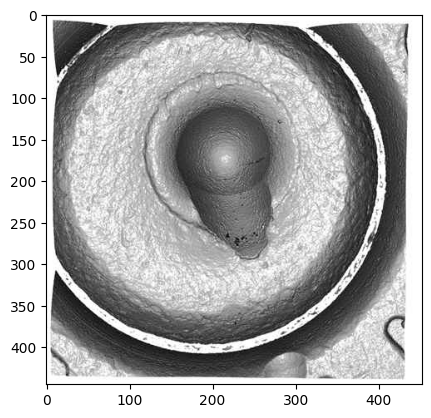

In [4]:
plt.imshow(image)

To begin with, we are loading the sample image that is in the document. Our goal is to:

- Identify the orientation of the image, and then rotate the image accordingly
- Identify the components in the image as specified in the requirements

Since we are trying to detect each component in the image without any data, we will make several assumptions along the way to compensate for the lack of training data. As we observe that the image structure is mostly decided by several concentric circles that are closed to the center of the image, we can apply **Hough transform** on the image gradient in order to detect the main circles (for this picture, there are 4 primary circles). From the circles that we detected, we can easily use bitwise manipulation in order to obtain the mask of each components, as desired.

# Find orientation and rotate image

Firstly, we find the orientation of the image, plot the arrows, and rotate the image accordingly. The main tool used in this part is the module `cv2.getRotationMatrix2D`, which is used to detect the orientation of the picture. After we get the orientation of the image, we can rotate the image using the function `cv2.warpAffine`. From here, we will work directly with the rotated image in order to identify the components.

Orientation: 23.891104426791774
Rotated image without arrows saved as rotated_img.jpg


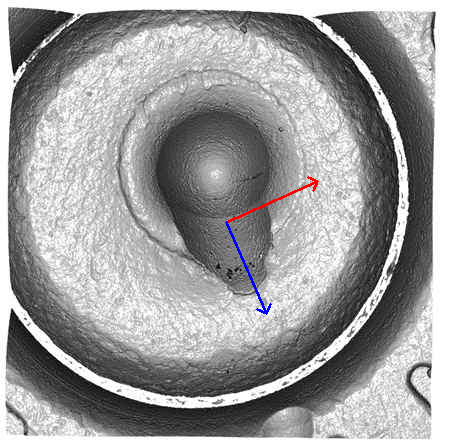

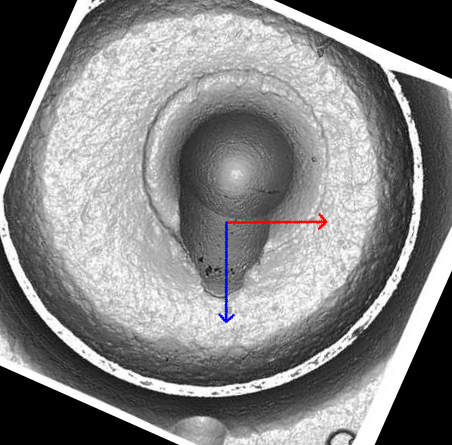

In [5]:
def find_orientation(image_path, save_path='rotated_img.jpg'):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply edge detection (can use other methods as well)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    # Calculate angle of detected lines
    angles = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            angle = theta * 45 / np.pi
            angles.append(angle)
            # cv2.line(img, (int(rho * np.cos(theta)), int(rho * np.sin(theta))),
            #          (int(rho * np.cos(theta) + 1000 * np.sin(theta)), int(rho * np.sin(theta) - 1000 * np.cos(theta))),
            #          (0, 0, 255), 2)

    # Calculate orientation as the average angle of detected lines
    if angles:
        orientation = sum(angles) / len(angles)
        print("Orientation:", orientation)

        # Draw arrows for x and y axes in the direction of the lines
        center = (img.shape[1] // 2, img.shape[0] // 2)

        # Rotate the image with arrows
        rows, cols = img.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D(center, -orientation, 1)  # Negative angle to match arrow direction

        # Save rotated image without arrows
        rotated_img_without_arrows = cv2.warpAffine(img, rotation_matrix, (cols, rows))
        cv2.imwrite(save_path, rotated_img_without_arrows)
        print(f"Rotated image without arrows saved as {save_path}")

        length = 100
        x_arrow_end = (int(center[0] + length * np.cos(np.radians(orientation))),
                       int(center[1] - length * np.sin(np.radians(orientation))))  # Corrected line
        y_arrow_end = (int(center[0] + length * np.sin(np.radians(orientation))),
                       int(center[1] + length * np.cos(np.radians(orientation))))  # Corrected line

        cv2.arrowedLine(img, center, x_arrow_end, (0, 0, 255), 2)
        cv2.arrowedLine(img, center, y_arrow_end, (255, 0, 0), 2)

        rotated_img_with_arrows = cv2.warpAffine(img, rotation_matrix, (cols, rows))

        cv2_imshow(img)
        cv2_imshow(rotated_img_with_arrows)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No lines detected.")

# Replace 'image_path' with the path to your image
find_orientation('img.jpg')

Now, we plot the rotated image together with the image gradient (and the enhanced version of it, by applying histogram equalization). Here, we are using **Scharr gradient**, a well known method to obtain the image gradient.

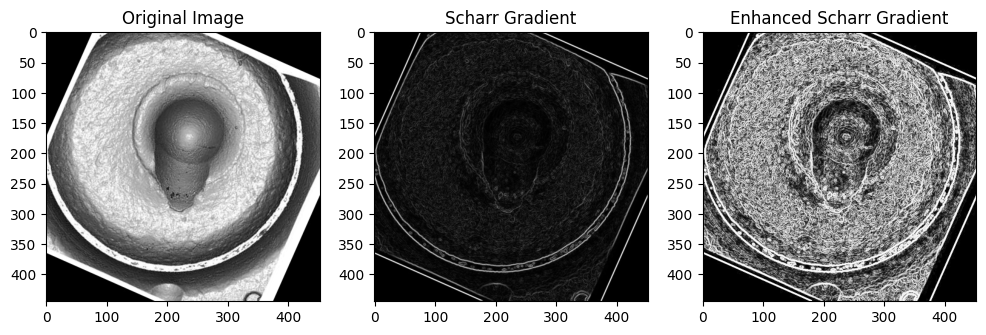

In [6]:
# Load the image
image_path = 'rotated_img.jpg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Scharr operator to compute the gradient
scharr_gradient_x = cv2.Scharr(original_image, cv2.CV_64F, 1, 0)
scharr_gradient_y = cv2.Scharr(original_image, cv2.CV_64F, 0, 1)

# Compute the magnitude of the gradient
scharr_gradient_magnitude = np.sqrt(scharr_gradient_x**2 + scharr_gradient_y**2)

# Enhance contrast using histogram equalization
normalized_gradient = cv2.normalize(scharr_gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)
equalized_gradient = cv2.equalizeHist(np.uint8(normalized_gradient))

# Display the original image, Scharr gradient, and enhanced gradient
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(scharr_gradient_magnitude), cmap='gray')
plt.title('Scharr Gradient')

plt.subplot(1, 3, 3)
plt.imshow(equalized_gradient, cmap='gray')
plt.title('Enhanced Scharr Gradient')

plt.show()

As we have discussed above, the image contains around 4 primary circles that are concentrical, with the center somewhere close to the center of the image. We thus use Hough transform to detect these circles, and by identifying these circles, we are 80% done with the desired task. This is because from these circles, we can derive each component using bitwise manipulation, and we are reducing the area to search for each component.

First, we convert the image to **grayscale**, apply **Gaussian blur** to reduce the noise of the image, and then apply the **Sobel operator** in order to obtain the image gradient. Subsequently, we apply the **Hough transform**. Some parameters in the Hough transform including `param1`, which refers to the edge threshold that will be used by the Canny edge detector (applied to a grayscale image), `param2`, which is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Moreover, we also have the `minRadius` and `maxRadius` parameters. Notice that in this case, since we don't require any data, we might need to tune the `minRadius` and `maxRadius` parameters so that we can find the desired circles.

Lastly, we need to identify the center for these four concentric circles. We might also need to try different values of the center coordinates which are expected to be somewhat closed to the center of the image, in order to obtain the desired circles. After this process, we will obtain four circles, which are plotted in green in the image below.

It is important to recognize that this approach may also transfer to other similar images, since we expect that the images to share similar dimensions, as well as these images might feature several main circles, which may have centers closed to the image center, and the ratio of the circles to the image sizes might be similar, etc. From here, we can select the appropriate number of circles, the coordinates of the centers of these circles, as well as the `minRadius` and the `maxRadius` parameters for the Hough transform.

[array([238, 168,  51], dtype=uint16)]
[array([230, 166,  98], dtype=uint16)]
[array([226, 174, 125], dtype=uint16)]
[array([220, 186, 186], dtype=uint16)]


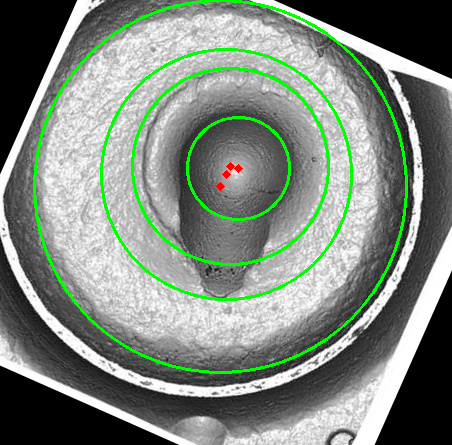

In [7]:
def detect_four_concentric_circles_on_gradient(image, param1=50, param2=30):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve circle detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Sobel operator to compute gradients in x and y directions
    gradient_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)

    # Compute the magnitude of the gradient
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    min_max_radius_arr = [(38, 55), (75, 99), (100, 130), (175, 200)]

    for element in min_max_radius_arr:
      # Use HoughCircles to detect circles in the gradient image
      circles = cv2.HoughCircles(
          np.uint8(gradient_magnitude),
          cv2.HOUGH_GRADIENT,
          dp=1,
          minDist=10,
          param1=param1,
          param2=param2,
          minRadius=element[0],  # Set the minimum radius for the largest circle
          maxRadius=element[1]  # Set the maximum radius for the largest circle
      )

      if circles is not None:
          # Convert coordinates to integers
          circles = np.uint16(np.around(circles))

          # Set the desired center coordinates
          new_center = np.array([230, 170])  # Adjust these coordinates as needed

          # Sort circles based on their proximity to the new center
          circles = sorted(circles[0, :], key=lambda x: np.linalg.norm(new_center - x[:2]))

          # Keep the top circles
          circles = circles[:1]

          print(circles)

          # Draw circles on the original image
          for i in circles:
              # Draw the outer circle
              cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
              # Draw the center of the circle
              cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

    return image

# Load the image
image_path = 'rotated_img.jpg'
original_image = cv2.imread(image_path)

# Set parameters for circle detection
param1 = 50
param2 = 30

# Detect three concentric circles in the gradient of the image
result_image = detect_four_concentric_circles_on_gradient(original_image, param1, param2)

# Display the original and result images
cv2_imshow(original_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Observe that we have four circles in the image above. Let's call them circle 1 to circle 4 from innermost to outermost. Firstly, we want to identify the object that situates inside circle 3, and subsequently we generate the corresponding masks. To do so, we will perform a series of bitwise manipulation to add and subtract different masks. Note that at the step where we apply the threshold using the `cv2.threshold` function, we need to find the appropriate threshold. At the end of the process, we will use the function `cv2.findContours` in order to extract the contours of the object that we identified.

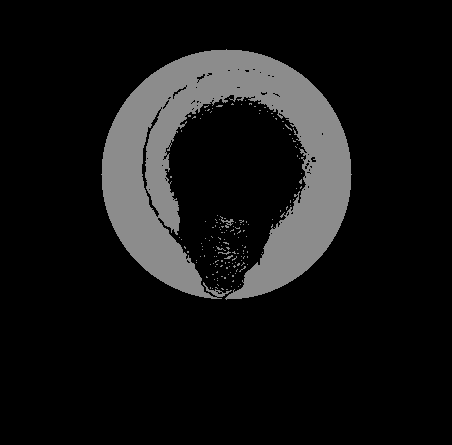

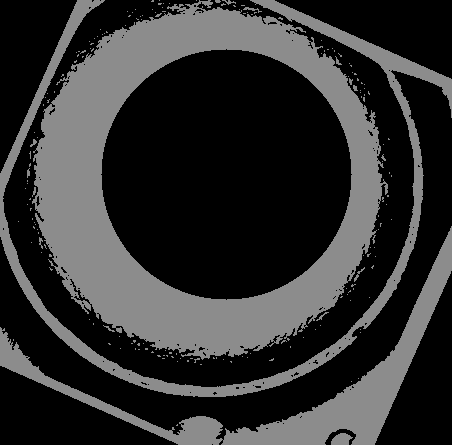

In [8]:
# Load the image
image_path = 'rotated_img.jpg'
original_image = cv2.imread(image_path)

# Set the center coordinates and radius of the first circle
first_circle_center = (238, 168)
first_circle_radius = 51

# Set the center coordinates and radius of the second circle
second_circle_center = (230, 166)
second_circle_radius = 98

# Set the center coordinates and radius of the third circle
third_circle_center = (226, 174)
third_circle_radius = 125

# Set the center coordinates and radius of the fourth circle
fourth_circle_center = (220, 186)
fourth_circle_radius = 186

# Create masks for the regions inside the first and third circles
first_circle_mask = np.zeros_like(original_image, dtype=np.uint8)
cv2.circle(first_circle_mask, first_circle_center, first_circle_radius, (255, 255, 255), thickness=-1)

third_circle_mask = np.zeros_like(original_image, dtype=np.uint8)
cv2.circle(third_circle_mask, third_circle_center, third_circle_radius, (255, 255, 255), thickness=-1)

# Convert the image to grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Invert the third circle mask to create a circular region outside the third circle
inverted_third_circle = cv2.bitwise_not(third_circle_mask)

# Apply the inverted circular mask to isolate the object excluding the boundary
object_mask = cv2.bitwise_and(gray_image, inverted_third_circle[:, :, 0])

# Apply thresholding to create a binary mask of the object
_, outside_mask = cv2.threshold(object_mask, 130, 140, cv2.THRESH_BINARY)

# Apply the circular masks to isolate the regions inside each circle
third_object_mask = cv2.bitwise_and(gray_image, third_circle_mask[:, :, 0])
first_object_mask = cv2.bitwise_and(gray_image, first_circle_mask[:, :, 0])

# Apply thresholding to create binary masks of the objects
_, binary_third_object_mask = cv2.threshold(third_object_mask, 130, 140, cv2.THRESH_BINARY)
_, binary_first_object_mask = cv2.threshold(first_object_mask, 130, 140, cv2.THRESH_BINARY)

# Use a logical XOR operation to obtain the part of the outer circle not overlapped with the inner circle
inside_mask = cv2.bitwise_xor(binary_first_object_mask, cv2.bitwise_not(binary_third_object_mask))

# Display the the masks that we found
cv2_imshow(cv2.bitwise_not(inside_mask))
cv2_imshow(outside_mask)


cv2.waitKey(0)
cv2.destroyAllWindows()

Next, we identify the red mask using the two masks that we found above, again using bitwise manipulation for different mask arrays.

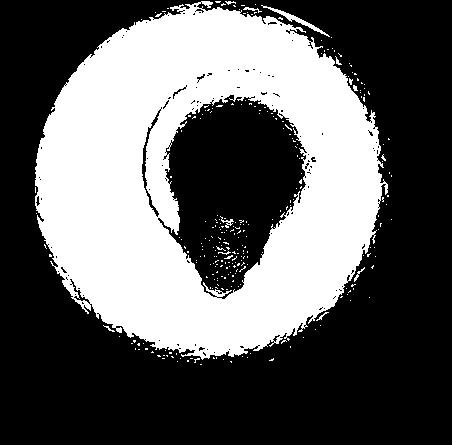

In [9]:
# Identify the red mask

first_circ = cv2.circle(np.zeros_like(original_image), first_circle_center, first_circle_radius, (255, 255, 255), thickness=-1)[:, :, 0]

# We create a slightly bigger and shifted version of the first circle mask in order to identify the blue mask

first_circ_bigger = cv2.circle(np.zeros_like(original_image), (first_circle_center[0], first_circle_center[1] - 20), first_circle_radius + 20, (255, 255, 255), thickness=-1)[:, :, 0]

third_circ = cv2.circle(np.zeros_like(original_image), third_circle_center, third_circle_radius, (255, 255, 255), thickness=-1)[:, :, 0]

fourth_circ = cv2.circle(np.zeros_like(original_image), fourth_circle_center, fourth_circle_radius, (255, 255, 255), thickness=-1)[:, :, 0]

second_circ = cv2.circle(np.zeros_like(original_image), second_circle_center, second_circle_radius, (255, 255, 255), thickness=-1)[:, :, 0]

second_circ = (second_circ != 0) * 255

red_mask = (outside_mask + fourth_circ-inside_mask) & fourth_circ

highlighted_red_mask = (red_mask != 0) * 255

cv2_imshow(highlighted_red_mask)

And then we identify the blue mask

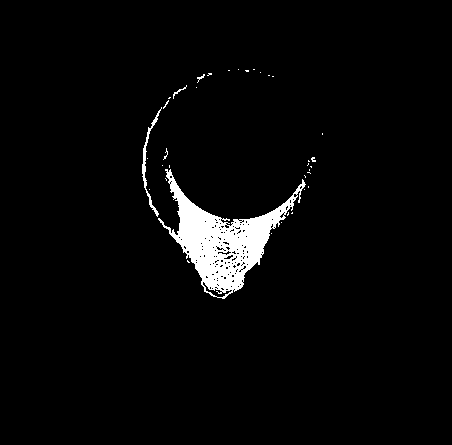

In [10]:
# Identify the blue mask

blue_mask = (third_circ - (first_circ_bigger + (highlighted_red_mask != 0) * 255) > 200) * 255
cv2_imshow(blue_mask)

Now, we put the masks altogether on the original image. Notice that the green part, which represents the aperture shear, is hard to observe in the original image as well as the image gradient plot. Although I have not highlighted the green band, I believe one heuristics to find it is to assume that it lies opposite to the blue vector, somewhere between circle 1 and circle 2. To figure this out correctly, I believe I would need some domain knowledge, but the main idea is that from the four circles that we have detected using Hough transform, combined with the direction of the blue arrow that we found in the previous part, we can identify the relevant components of the image seamlessly.

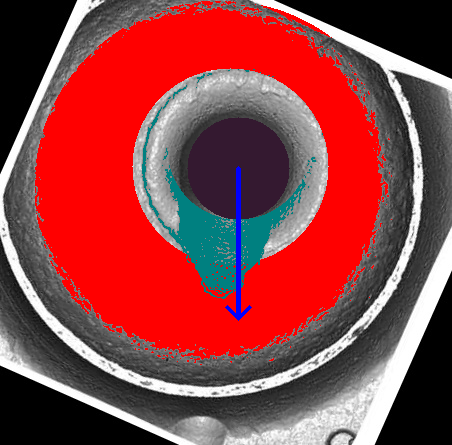

In [11]:
# Putting all the mask together

inverted_second_circ = cv2.bitwise_not(second_circ)

final_red_mask = cv2.bitwise_xor(second_circ, highlighted_red_mask) & inverted_second_circ

# Load the image
image_path = 'rotated_img.jpg'
original_image = cv2.imread(image_path)

# Apply the mask to color the highlighted region
highlighted_image = original_image.copy()

# Red mask
highlighted_image[final_red_mask != 0] = (0, 0, 255)

# Purple mask
highlighted_image[first_circ != 0] = (48, 25, 52)

# Blue mask
highlighted_image[blue_mask != 0] = (128, 128, 0)

# Blue arrow

# Get the center coordinates of the image
center = (highlighted_image.shape[1] // 2, highlighted_image.shape[0] // 2)

# Define the length and width of the arrow
arrow_length = 150
arrow_width = 3

# Draw a blue arrow pointing down from the center of the first circle
cv2.arrowedLine(highlighted_image, first_circle_center, (first_circle_center[0], first_circle_center[1] + arrow_length), (255, 0, 0), arrow_width)

cv2_imshow(highlighted_image)

In the last part of this document, I want to experiment with a pretrained model. Since we don't require any data in this case, we can just use the auto mask generator from the open-sourced `segment_anything` library. We can observe that the result is quite good, although it is not the same as what we expect from the requirements. I believe that by fine-tuning this model with some data, it would generalize well on similar images.

# Try SegmentAnything model (SAM) from Meta to generate mask (Optional)

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-01-14 16:38:21--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.15, 52.84.251.114, 52.84.251.106, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   124MB/s    in 24s     

2024-01-14 16:38:44 (104 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
# Apply guided filter
guided_filtered_image = cv2.ximgproc.guidedFilter(image, image, radius=5, eps=0.1)

masks = mask_generator_2.generate(guided_filtered_image)

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

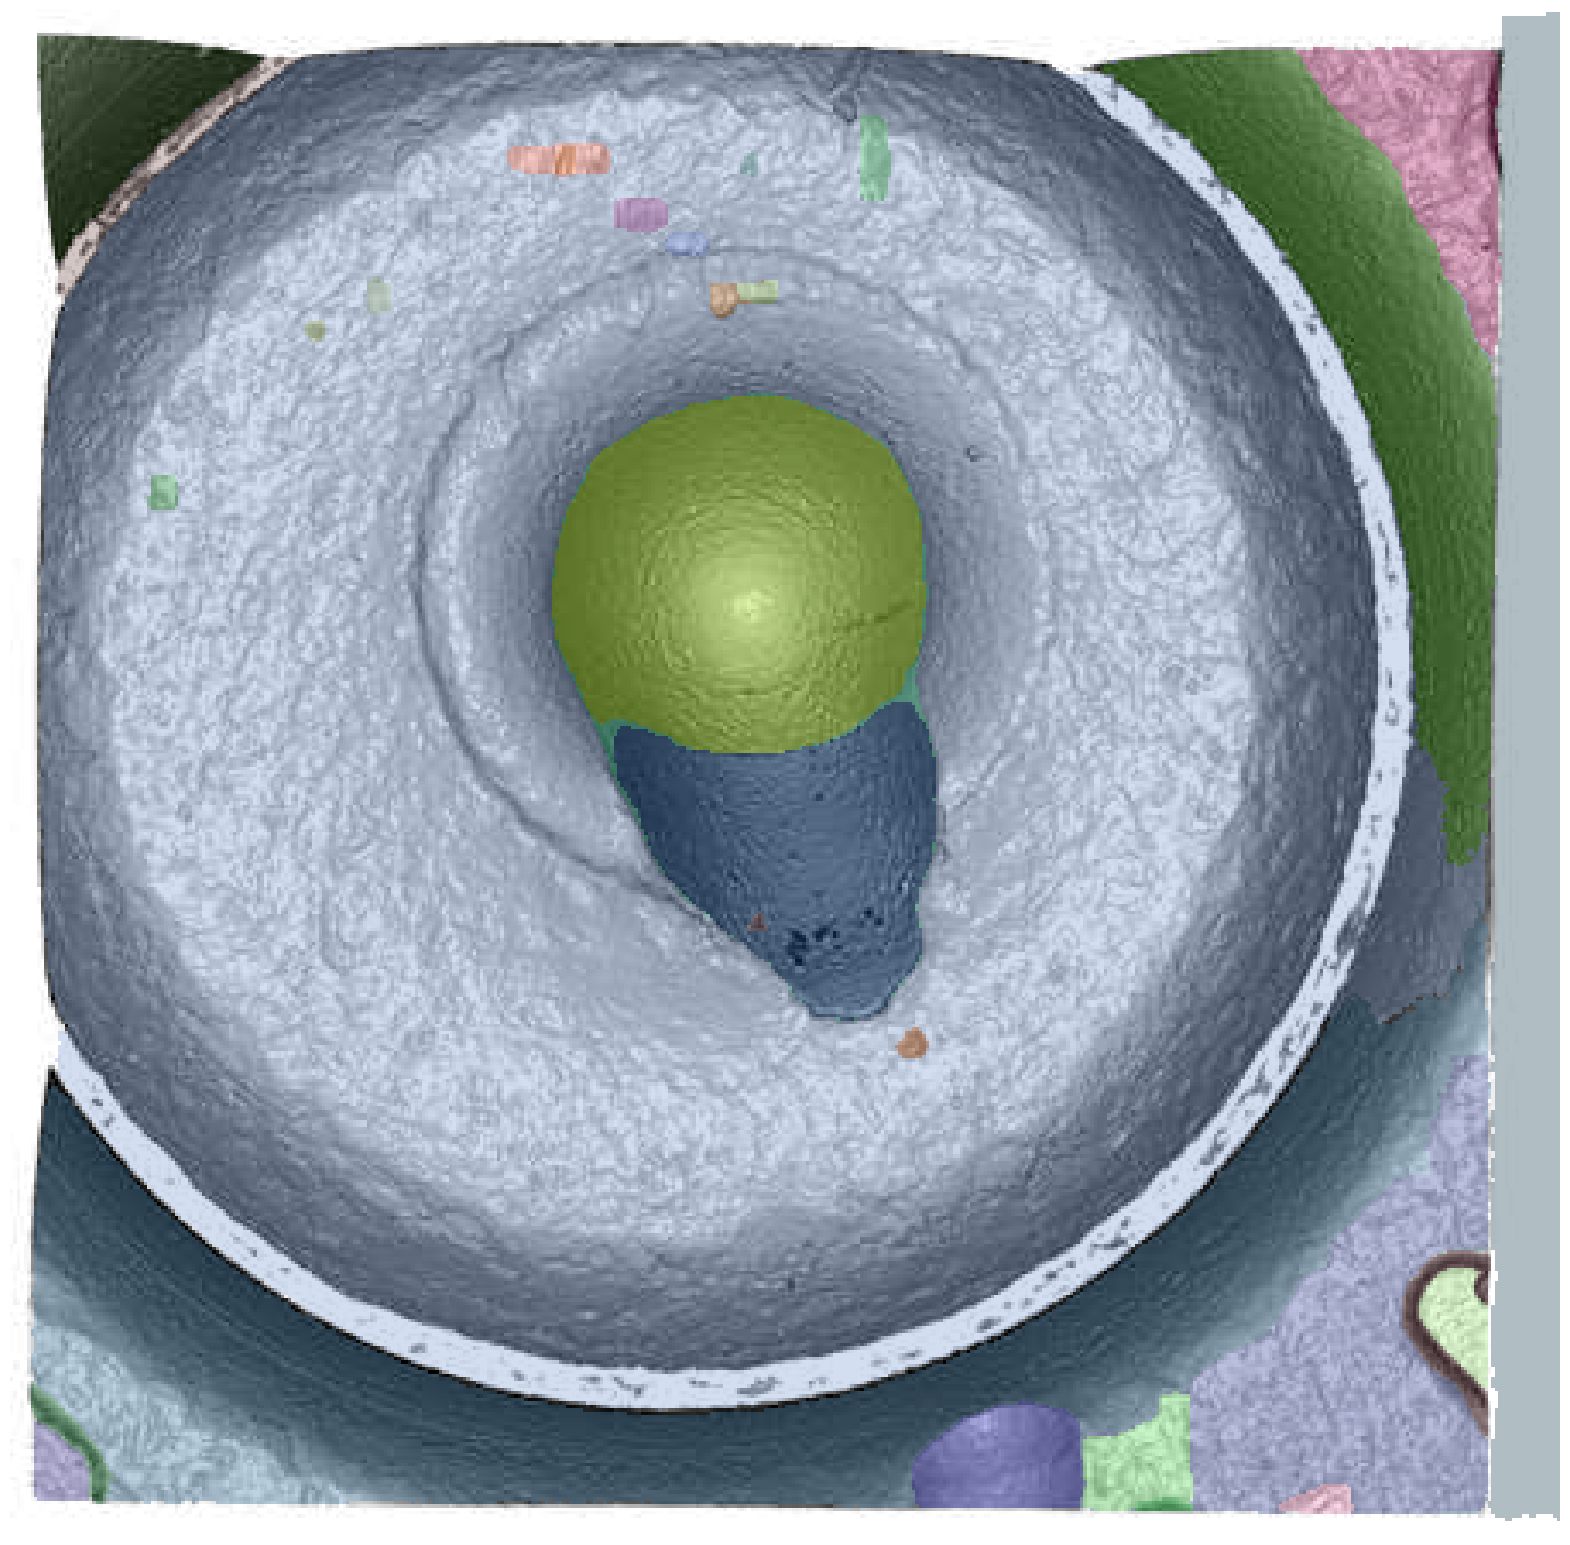

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()